# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

### Robin Adler (191845)

In [ ]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [6]:
train[0][0].shape

torch.Size([1, 28, 28])

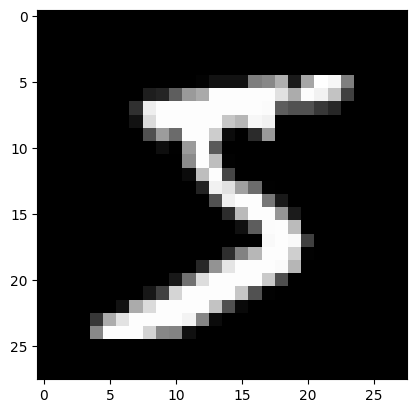

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

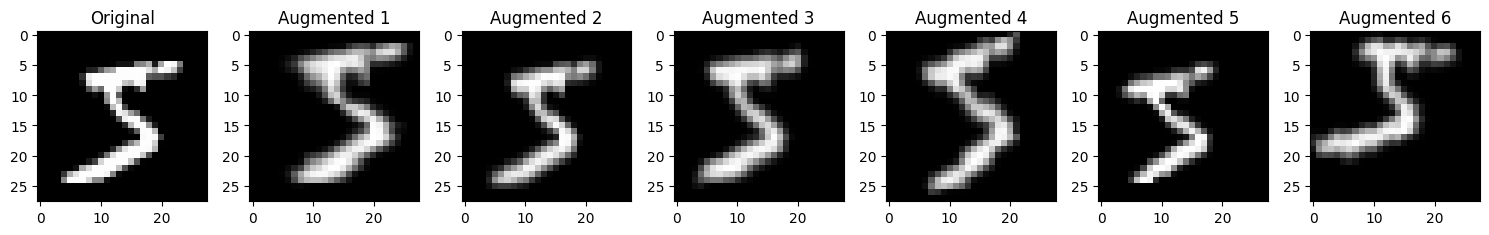

In [8]:
from torchvision import transforms

# Define the augmentations
augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
])

# Apply augmentations and visualize examples
fig, axes = plt.subplots(1, 7, figsize=(15, 3))
axes[0].imshow(train[0][0].reshape((28, 28)), cmap='gray')
axes[0].set_title("Original")
for i in range(6):
    augmented_image = augmentations(train[0][0])
    axes[i+1].imshow(augmented_image.reshape((28, 28)), cmap='gray')
    axes[i+1].set_title(f"Augmented {i+1}")
plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLPAutoencoder(nn.Module):
    def __init__(self):
        super(MLPAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(decoded.size(0), 1, 28, 28)

# Instantiate the model
model = MLPAutoencoder()
model.to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Training finished.")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10, Loss: 0.0373
Epoch 2/10, Loss: 0.0156
Epoch 3/10, Loss: 0.0117
Epoch 4/10, Loss: 0.0099
Epoch 5/10, Loss: 0.0088
Epoch 6/10, Loss: 0.0080
Epoch 7/10, Loss: 0.0074
Epoch 8/10, Loss: 0.0069
Epoch 9/10, Loss: 0.0065
Epoch 10/10, Loss: 0.0062
Training finished.
Test Loss: 0.0060


## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [10]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

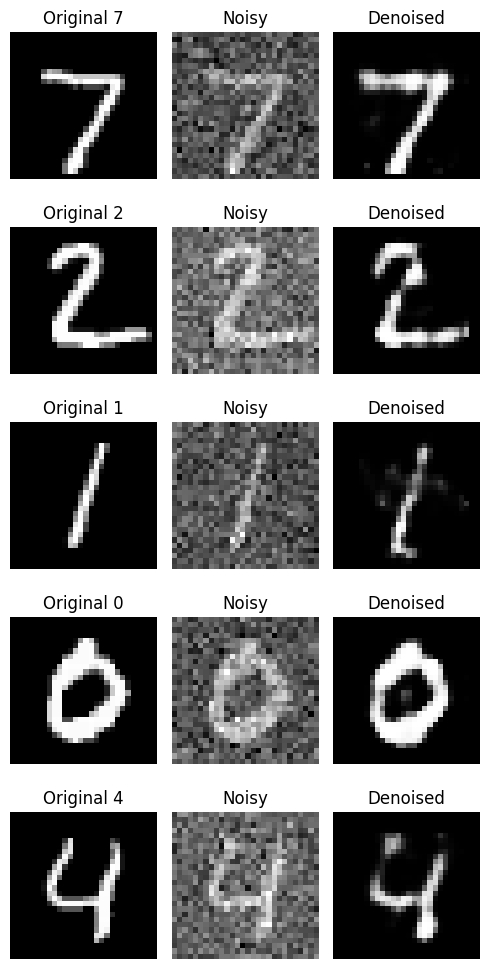

In [31]:
noise = AddGaussianNoise(mean=0., std=0.3)
num = 5
fig, axes = plt.subplots(num, 3, figsize=(5, 10))

with torch.no_grad():
    for i in range(num):
        original_image, y = test[i]
        original_image = original_image.unsqueeze(0).to(device)
        noisy_image = noise(original_image)
        denoised_image = model(noisy_image)

        original_image = original_image.squeeze().cpu().numpy()
        noisy_image = noisy_image.squeeze().cpu().numpy()
        denoised_image = denoised_image.squeeze().cpu().numpy()

        axes[i, 0].imshow(original_image.reshape((28, 28)), cmap='gray')
        axes[i, 0].set_title("Original " + str(y))
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_image.reshape((28, 28)), cmap='gray')
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(denoised_image.reshape((28, 28)), cmap='gray')
        axes[i, 2].set_title("Denoised")
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

model.eval()
latent_vectors = []
labels = []

# Extract latent vectors from the training set
# Just the encoder part of the model (latent vector)
with torch.no_grad():
    for data in train_loader:
        images, targets = data
        images = images.to(device)
        # Flatten and encode
        encoded = model.encoder(images.view(images.size(0), -1))
        latent_vectors.append(encoded.cpu().numpy())
        labels.append(targets.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_assignments = kmeans.fit_predict(latent_vectors)

# Evaluate clustering quality
ari = adjusted_rand_score(labels, cluster_assignments)
nmi = normalized_mutual_info_score(labels, cluster_assignments)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.1453
Normalized Mutual Information (NMI): 0.2603
